First cell just downloads the CSV for the data. Should take about a minute for one season. You can change the start dates if you like.

In [ ]:
import pybaseball as pb
import pandas as pd

# Documentation for pybaseball: https://github.com/jldbc/pybaseball
# Information on CSV fields from statcast: https://baseballsavant.mlb.com/csv-docs
pitch_data = pb.statcast("2025-01-01", "2025-9-30")

# go to the second link if you want to see what's available
pitch_data = pitch_data[[
    "release_speed", "release_pos_x", "release_pos_z", "release_pos_y", "player_name", "events",
    "launch_angle", "strikes", "balls", "plate_x", "plate_z", "outs_when_up", "release_spin_rate",
    "spin_axis", "release_extension", "effective_speed", "p_throws", "stand", "pitch_type", "pitch_name"]]

filename = f"statcast_pitch_data_2025.csv"
pitch_data.to_csv(filename, index=False)
print(f"Data saved to {filename}")

This is a large query, it may take a moment to complete


C:\Users\ethan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\pybaseball\statcast.py:50: UserWarning: 
That's a nice request you got there. It'd be a shame if something were to happen to it.
We strongly recommend that you enable caching before running this. It's as simple as `pybaseball.cache.enable()`.
Since the Statcast requests can take a *really* long time to run, if something were to happen, like: a disconnect;
gremlins; computer repair by associates of Rudy Giuliani; electromagnetic interference from metal trash cans; etc.;
you could lose a lot of progress. Enabling caching will allow you to immediately recover all the successful
subqueries if that happens.
  warnings.warn(_OVERSIZE_WARNING)


Skipping offseason dates


  0%|          | 0/200 [00:00<?, ?it/s]C:\Users\ethan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\pybaseball\datahelpers\postprocessing.py:59: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  data_copy[column] = data_copy[column].apply(pd.to_datetime, errors='ignore', format=date_format)
  0%|          | 1/200 [00:00<02:17,  1.44it/s]C:\Users\ethan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\pybaseball\datahelpers\postprocessing.py:59: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  data_copy[column] = data_copy[column].apply(pd.to_datetime, errors='ignore', format=date_format)
  2%|▏         | 3/200 [

Data saved to statcast_pitch_data_2025.csv


Here's a scatterplot I made to visualize different release points. The two distinct clusters are lefty and righty pitchers.

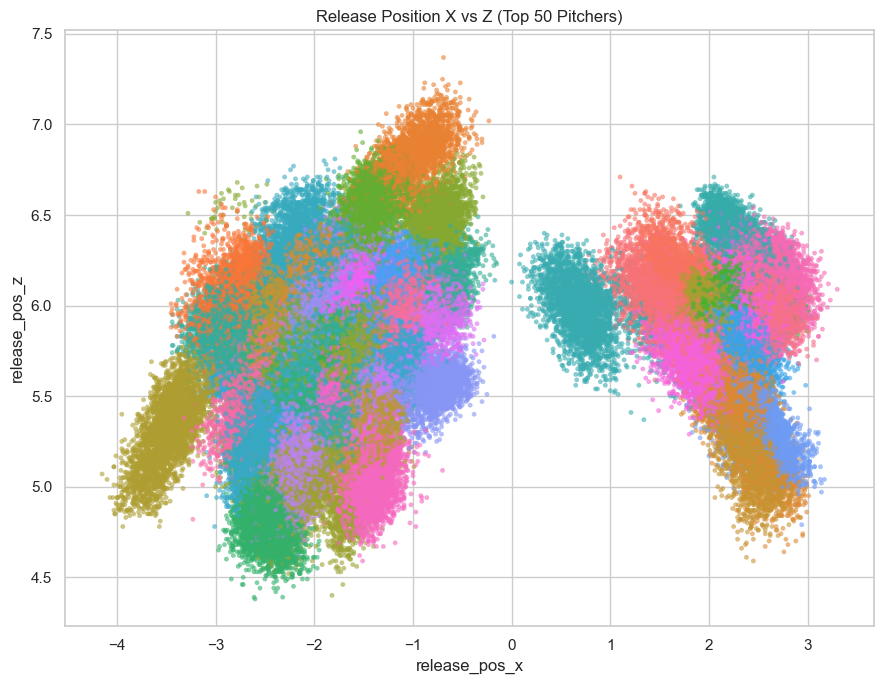

In [ ]:
from sklearn.preprocessing import StandardScaler
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.decomposition import PCA, TruncatedSVD
# Scatter plot of release_pos_x vs release_pos_y, labeled by pitcher (top N by pitch count)

# Load only needed columns (release_pos_y was dropped from `data`)
pos_df = pd.read_csv(filename, usecols=["player_name", "release_pos_x", "release_pos_z"]).dropna()

# Limit to top N pitchers to keep the plot readable
top_n = 50
top_pitchers = pos_df["player_name"].value_counts().head(top_n).index
plot_df = pos_df[pos_df["player_name"].isin(top_pitchers)].copy()

plt.figure(figsize=(9, 7))
sns.scatterplot(
    data=plot_df,
    x="release_pos_x",
    y="release_pos_z",
    hue="player_name",
    s=12,
    alpha=0.6,
    linewidth=0,
    legend= False
)

# I commented this out for readability. With a smaller number of pitchers you can label
# the clusters with their names
# Label clusters by pitcher at their centroid
# centroids = plot_df.groupby("player_name", as_index=False)[["release_pos_x", "release_pos_z"]].mean()
# for _, r in centroids.iterrows():
#     plt.text(
#         r["release_pos_x"],
#         r["release_pos_z"],
#         r["player_name"],
#         fontsize=8,
#         weight="bold",
#         ha="center",
#         va="center",
#         bbox=dict(boxstyle="round,pad=0.15", fc="white", ec="none", alpha=0.7)
#     )

plt.title(f"Release Position X vs Z (Top {top_n} Pitchers)")
plt.xlabel("release_pos_x")
plt.ylabel("release_pos_z")
# plt.legend(title="Pitcher", fontsize=8, title_fontsize=9, loc="best", frameon=True)
plt.tight_layout()
plt.show()

This plot below shows how a pitcher's release point varies with different pitches

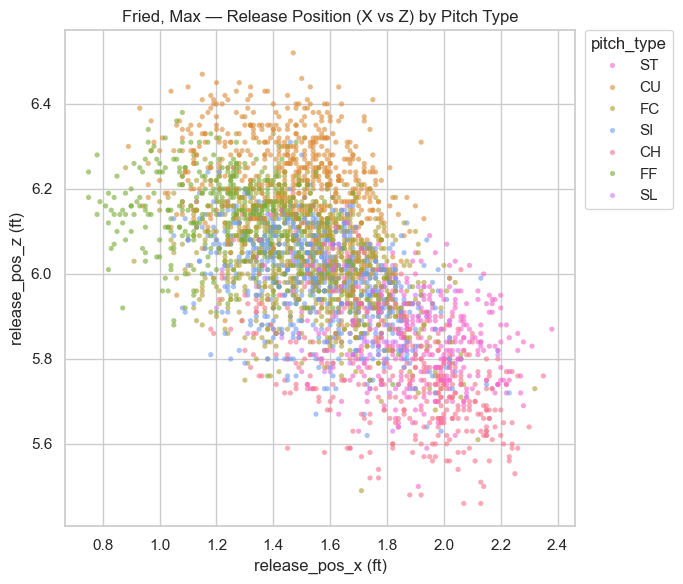

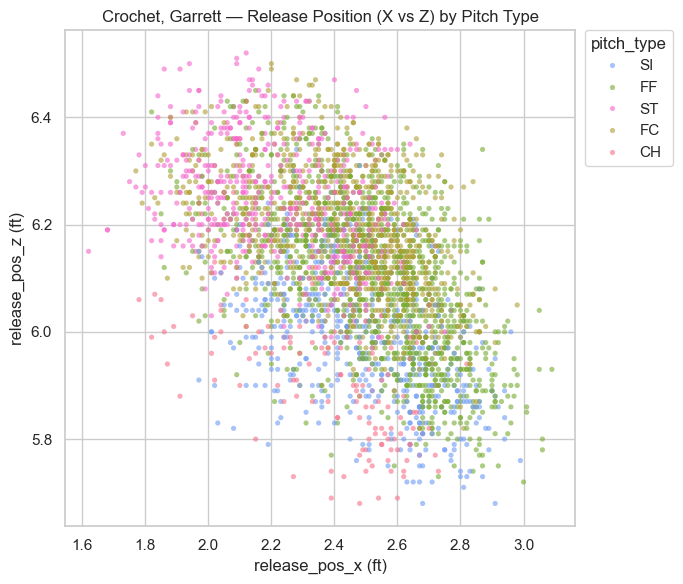

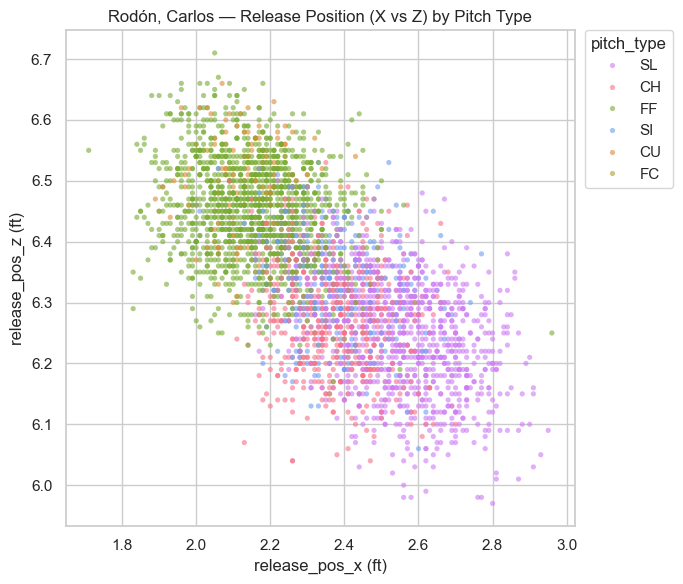

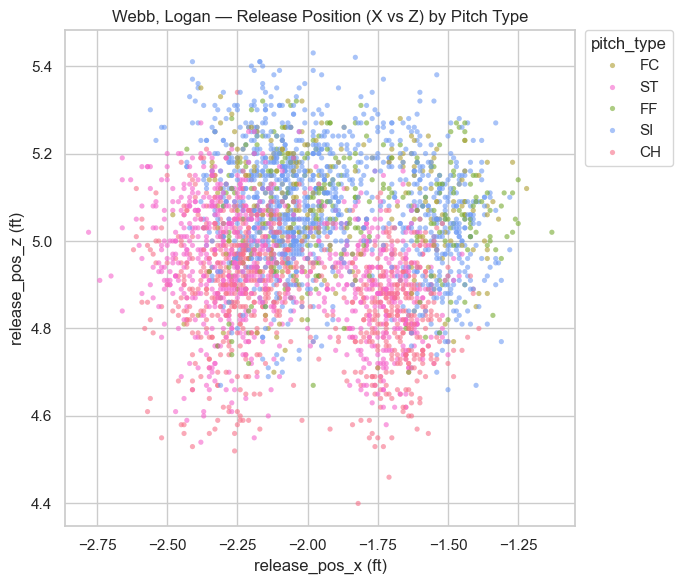

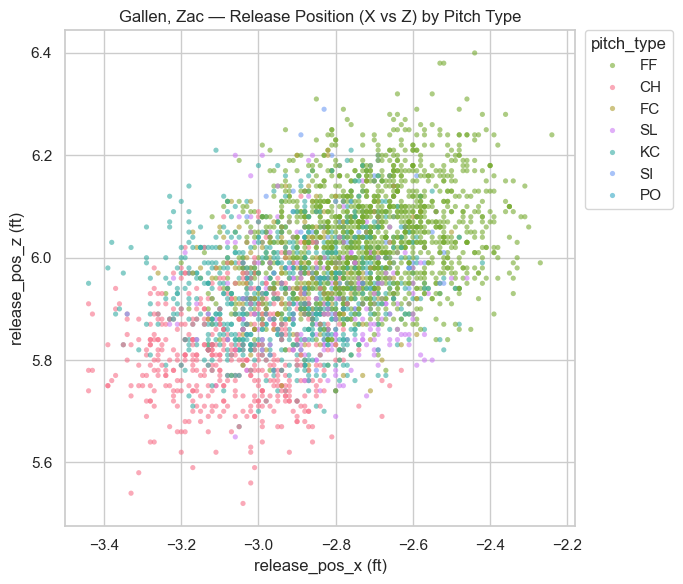

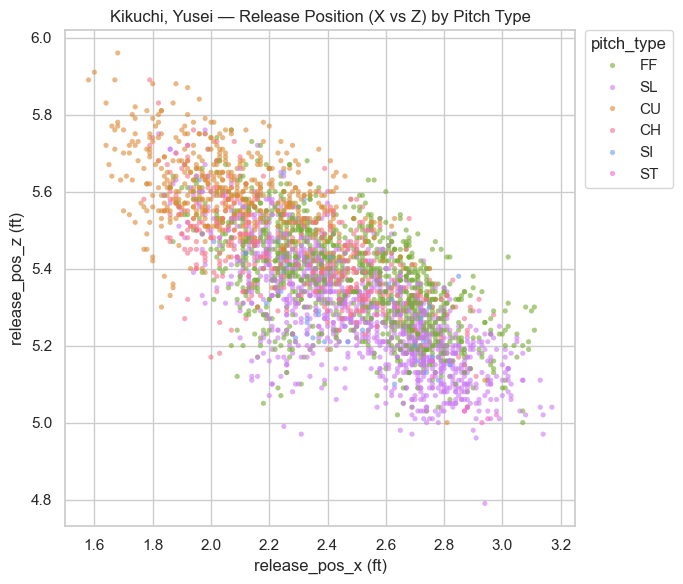

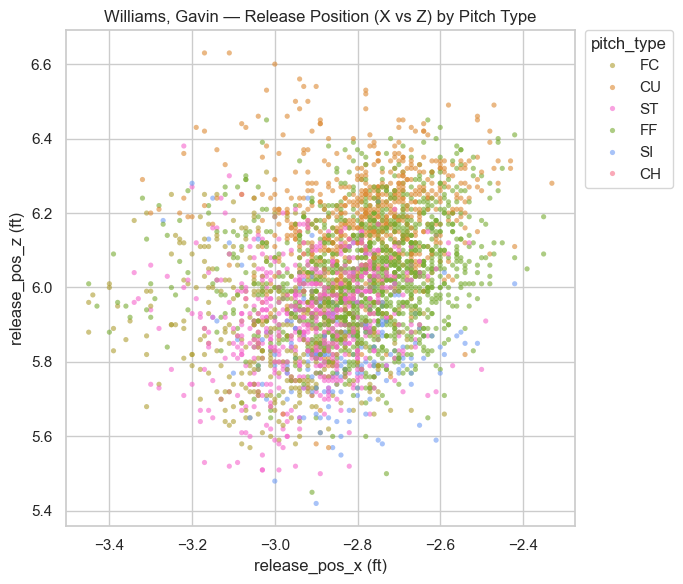

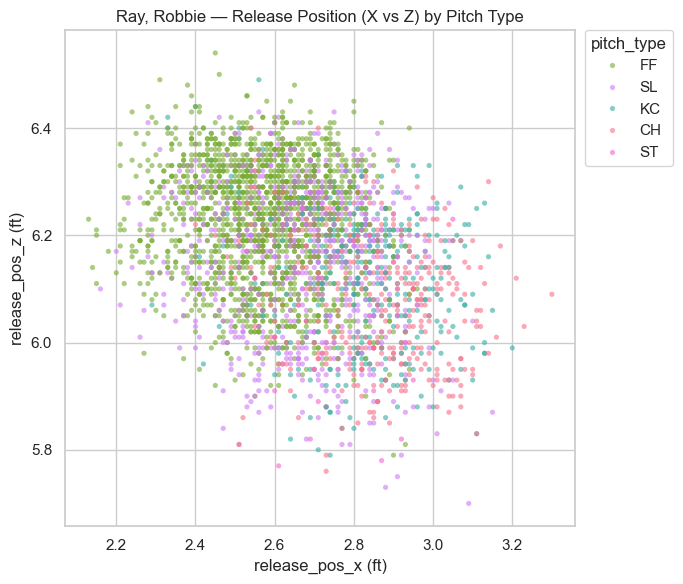

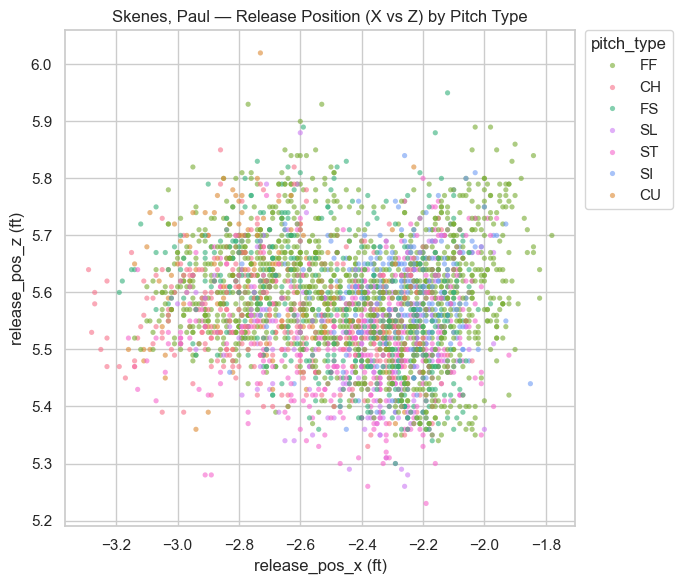

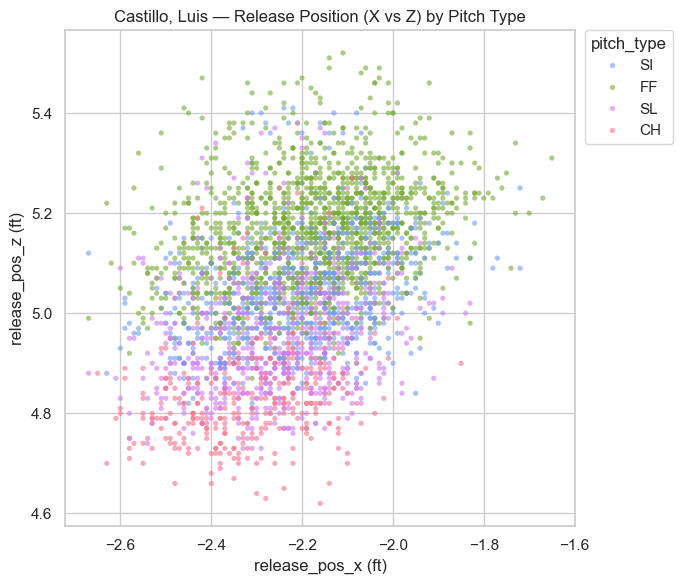

In [ ]:
# Scatter plots of release_pos_x vs release_pos_z per pitcher, colored by pitch_type
rel_df = pd.read_csv(
    filename,
    usecols=["player_name", "pitch_type", "release_pos_x", "release_pos_z"]
).dropna(subset=["release_pos_x", "release_pos_z", "pitch_type"])

# Choose which pitchers to plot
# pitchers = (
#     pitchers_to_plot
#     if 'pitchers_to_plot' in globals()
#     else eligible_pitchers
#     if 'eligible_pitchers' in globals()
#     else rel_df['player_name'].value_counts().head(10).index.tolist()
# )
pitchers = rel_df['player_name'].value_counts().head(10).index.tolist()
# Consistent color mapping across pitchers for all pitch types present in selection
types_in_selection = (
    rel_df[rel_df["player_name"].isin(pitchers)]["pitch_type"].dropna().unique()
)
types_in_selection = sorted(types_in_selection.tolist())
palette = sns.color_palette("husl", len(types_in_selection))
type_to_color = dict(zip(types_in_selection, palette))

for name in pitchers:
    sub = rel_df[rel_df["player_name"] == name]
    if sub.empty:
        continue

    plt.figure(figsize=(7, 6))
    sns.scatterplot(
        data=sub,
        x="release_pos_x",
        y="release_pos_z",
        hue="pitch_type",
        palette=type_to_color,
        alpha=0.6,
        s=14,
        linewidth=0
    )
    plt.title(f"{name} — Release Position (X vs Z) by Pitch Type")
    plt.xlabel("release_pos_x (ft)")
    plt.ylabel("release_pos_z (ft)")
    plt.legend(title="pitch_type", bbox_to_anchor=(1.02, 1), loc="upper left", borderaxespad=0.)
    plt.tight_layout()
    plt.show()

   stand p_throws  opp_hand
5      L        L         0
13     L        L         0
14     R        L         1
15     R        L         1
18     L        L         0


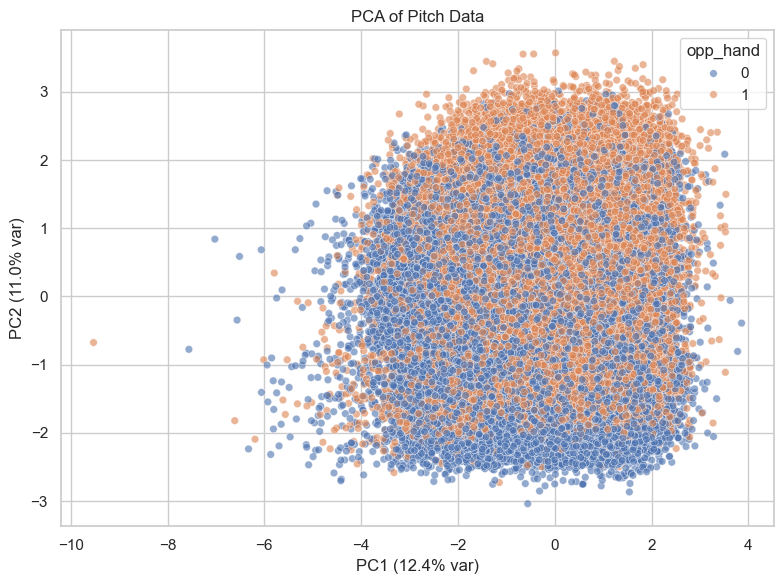

In [ ]:
import numpy as np
from sklearn.decomposition import TruncatedSVD


filename = f"statcast_pitch_data_2025.csv"
data = pd.read_csv(filename)
data.dropna(inplace=True)

data.drop(['release_speed', 'release_pos_y'], axis=1, inplace=True)

# I messed with the handedness feature to make it numerical
# Instead of having both the handedness of the pitcher and batter,
# It just indicates if their handedness is the same or different
if {'stand', 'p_throws'}.issubset(data.columns):
    data['opp_hand'] = (data['stand'] != data['p_throws']).astype(int)
    if 'same_hand' in data.columns:
        data.drop(columns=['same_hand'], inplace=True)
else:
    raise KeyError("Required columns 'stand' and 'p_throws' not found")

print(data[['stand', 'p_throws', 'opp_hand']].head())

numeric_data = data.select_dtypes(include=['number'])

scaler = StandardScaler()
scaled_data = scaler.fit_transform(numeric_data)

# I attempted to extract features but there isn't really an elbow point
# Hard to find important components.

# Perform PCA to 2 components
pca = PCA(n_components=3)
pca_result = pca.fit_transform(scaled_data)
pca_df = pd.DataFrame(pca_result, columns=['PC1', 'PC2', 'PC3'], index=data.index)
meta_cols = [c for c in ['player_name', 'p_throws', 'stand', 'events', 'opp_hand'] if c in data.columns]
pca_df = pca_df.join(data[meta_cols])

# Visualize
sns.set(context="notebook", style="whitegrid")
evr = pca.explained_variance_ratio_

plt.figure(figsize=(8,6))
sns.scatterplot(data=pca_df, x='PC1', y='PC2',
                hue='opp_hand' if 'opp_hand' in pca_df.columns else None,
                alpha=0.6, s=30)
plt.xlabel(f"PC1 ({evr[0]*100:.1f}% var)")
plt.ylabel(f"PC2 ({evr[1]*100:.1f}% var)")
plt.title("PCA of Pitch Data")
plt.tight_layout()
plt.show()
